In [1]:
# To download http://archive.ics.uci.edu/ml/datasets/gas+sensors+for+home+activity+monitoring

import time
from tqdm import tqdm

# import numpy as np

from autograd import numpy as np
from autograd import grad

import pandas as pd
from numpy.linalg import norm, eigvals

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Problem

In [5]:
MAX_SAMPLES = 6000
LAMBDA = 1e-2
GAMMA = 1e-1
EPS = 1e-3
MU = 1e-1  # Ideally, ~ EPS

In [6]:
X = pd.read_csv('HT_Sensor_dataset.dat' , sep='  ', header=1)
y = pd.read_csv('HT_Sensor_metadata.dat', sep='\t', header=0, names=[0], usecols=[2]).iloc[:,0]

y = y.map({'banana': 1, 'wine': -1, 'background': None}).dropna().astype(float)

X = X[X.iloc[:,0].isin(y.index)].sample(frac=1, random_state=1).head(MAX_SAMPLES)

y = y.iloc[X.iloc[:,0]].values[np.newaxis].T
X = X.iloc[:,1:].astype(float).values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3)
X_train, y_train = X, y
size = X_train.shape[0]

In [7]:
K = np.exp(-GAMMA * norm(X_train[..., :, None, :] - X_train[..., None, :, :], axis=-1) ** 2)

In [8]:
def h(point):
    x = point[1:]
    return LAMBDA/2 * x @ K @ x


def dh(point):
    x = point[1:]
    value = LAMBDA * K @ x
    return np.insert(value, 0, 0)


def g(point):
    x0 = point[0]
    x = point[1:]
    
    # Simple smoothing
#     value = np.zeros_like(x)
#     value = np.where(margin <= 1, np.power(1 - margin, 2) / (2*MU), 0)
#     value = np.where(margin <= 1 - MU, 1 - margin - MU/2, value)
        
    # Dual smoothing
    margin = y_train[..., 0] * (x0 + x @ K)
    value = MU * np.log(1 + np.exp(1/MU * (1 - margin)))
    
    return np.mean(value)


def dg(point):
    x0 = point[0]
    x = point[1:]
     
    value = np.zeros_like(point)
    
    # Simple smoothing
#     coef = np.zeros_like(x)
#     coef = np.where(margin <= 1, -1/MU * (1 - margin) * y_train[..., 0], coef)
#     coef = np.where(margin <= 1 - MU, -y_train[..., 0], coef)
    
    # Dual smoothing
    margin = y_train[..., 0] * (x0 + x @ K)
    coef = -np.exp(1/MU) / (np.exp(margin/MU) + np.exp(1/MU)) * y_train[..., 0]
    
    value[0] = np.mean(coef)
    value[1:] = np.mean(coef * K, axis=-1)
    
    return value


def dg_stoch(point, i):
    x0 = point[0]
    x = point[1:]

    # Simple smoothing
#     if margin <= 1 - MU:
#         coef = -y_train[i, 0]
#     elif margin <= 1:
#         coef = -1/MU * (1 - margin) * y_train[i, 0]
#     else:
#         coef = 0

    # Dual smoothing
    margin = y_train[i, 0] * (x0 + x @ K[i])
    coef = -np.exp(1/MU) / (np.exp(margin/MU) + np.exp(1/MU)) * y_train[i, 0]
        
    value = np.zeros_like(point)
    value[0] = coef
    value[1:] = coef * K[i]
    
    return value 


def f(x):
    return h(x) + g(x)


def df(x):
    return dh(x) + dg(x)   

In [9]:
lambdas = eigvals(K)
lambda_max = np.max(lambdas)

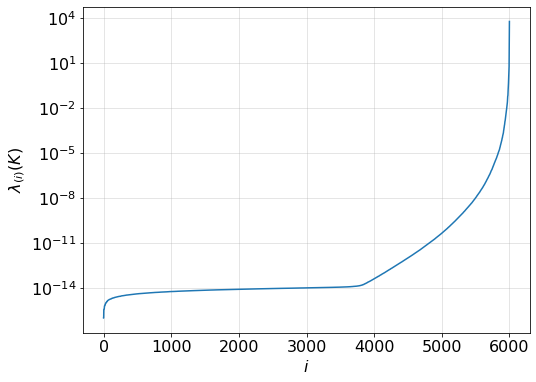

In [10]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.xlabel('$i$')
plt.ylabel('$\\lambda_{(i)}(K)$')
plt.semilogy(np.sort(np.abs(lambdas)))
plt.grid(alpha=0.4)

plt.show()

In [11]:
def fit_lipschitz_condition(oracle, R=10.0, probes=10, stoch=False):
    L = 1e-15    
    for j in range(20):
        for i in range(probes):
            x, y = R * (2 * np.random.random((2, size + 1)) - 1)

            # L = max(L, norm(oracle(x) - oracle(y)) / norm(x - y))

            if stoch:
                i = np.random.randint(size)
                while norm(oracle(x, i) - oracle(y, i)) > L * norm(x - y):
                    L *= 1.3
            else:
                while norm(oracle(x) - oracle(y)) > L * norm(x - y):
                    L *= 1.3

        R /= 2.0
    
    return L

# L_g = fit_lipschitz_condition(dg)
# print('L_g =', L_g)
L_g = 1/EPS
L_stoch = 1/EPS

# L_h = fit_lipschitz_condition(dh)
lambda_max = lambda_max.real
L_h = LAMBDA * lambda_max
print('L_h =', L_h)

# L = fit_lipschitz_condition(df)
# print('L =', L)
# print('or maybe')
L = L_h + L_g
print('L =', L)

# L_stoch = fit_lipschitz_condition(dg_stoch, stoch=True)
# print('L_stoch =', L_stoch)

L_h = 57.4204287148235
L = 1057.4204287148234


In [12]:
# print("in theory,")

# if np.iscomplex(lambda_max):
#     print('WARNING:', 'lambda_max(K) is complex')
# lambda_max = lambda_max.real

# if USE_THEORETICAL_Lh:
#     L_h = LAMBDA * lambda_max

# print("L_h =", LAMBDA * lambda_max)

## [Katyusha$^{\text{ns}}$](https://arxiv.org/pdf/1603.05953.pdf)

In [13]:
def Katyusha(coef_1, center_1, coef_2, center_2, line_approx, warm_start=True, S=5):
    dg_calls = 0
    dh_calls = 0
    
    m = 100 # 2 * size
    tau_2 = 0.5

    if warm_start:
        x_0 = np.copy(center_2)
    else:
        x_0 = np.copy(center_1)

    y = np.copy(x_0); z = np.copy(x_0); x_tilde = np.copy(x_0)
    
    for s in range(S):
        mu = dg(x_tilde)
        dg_calls += size
        
        tau_1 = 2 / (s + 4)
        alpha = 1 / (3 * tau_1 * L_stoch)
        
        y_mean = np.zeros_like(y)
        
        for j in range(m):
            k = s * m + j

            x = tau_1 * z + tau_2 * x_tilde + (1 - tau_1 - tau_2) * y
            
            i = np.random.randint(size)
            Nabla = mu + dg_stoch(x, i) - dg_stoch(x_tilde, i)
            dg_calls += 2
            
            z_new = (1/alpha * z + coef_1 * center_1 + coef_2 * center_2 - Nabla - line_approx) / (1/alpha + coef_1 + coef_2)
            
            y = x + tau_1 * (z_new - z)
            z = np.copy(z_new)
            
            y_mean += 1/m * y

        x_tilde = np.copy(y_mean)

    return x_tilde, dg_calls, dh_calls

## [SAE](https://arxiv.org/pdf/2002.02706.pdf)

In [14]:
def GMCO(y_0, T):
    dg_calls = 0
    dh_calls = 0
    
    y = np.copy(y_0)
    
    for _ in range(T):
        
        line_approx = dh(y)
        y, dg_calls_, dh_calls_ = Katyusha(L, y_0, L_h, y, line_approx)
        
        dg_calls += dg_calls_
        dh_calls += dh_calls_ + 1
        
#         if norm(df(y) + L * (y - y_0)) <= L/2 * norm(y - y_0):
#             break
    
    return y, dg_calls, dh_calls

In [15]:
def SAE(x_0, T, verbose=True):
    dg_calls = 0
    dh_calls = 0
    
    vals = []; times = []; dg_list = []; dh_list = []
    
    x = np.copy(x_0); y = np.copy(x_0); z = np.copy(x_0)
    A = 0.0
    
    vals.append(f(y))
    times.append(0.0)
    dg_list.append(0)
    dh_list.append(0)
    
    toc = 0
    
    for t in range(T):
        with Timer() as t1:
            a = (1/L + np.sqrt(1 / L**2 + 4 * A / L)) / 2
            A_new = A + a

            x = (A * y + a * z) / A_new
            y, dg_calls_, dh_calls_ = GMCO(x, 1)
        
        dg_calls += dg_calls_
        dh_calls += dh_calls_
        
        with Timer() as t2:
            z -= a * df(y)
            A = A_new
        
        dg_calls += size
        dh_calls += 1
        
        toc += t1.interval + t2.interval
        
        vals.append(f(y))
        times.append(toc)
        dg_list.append(dg_calls)
        dh_list.append(dh_calls)
        
        if verbose:
            print(f'iter = {t}, f = {vals[-1]}')
        
    return np.array(vals), times, dg_list, dh_list

## [AGS](https://arxiv.org/pdf/1609.04905.pdf)

In [16]:
def ProxAG(x_upper, x, T, lam, k, beta, optimize_linear_approx=True, line_approx_h=None):
    nu = 1  # Euclidean setup
    dg_calls = 0
    dh_calls = 0
    
    u_tilde = np.copy(x_upper); u = np.copy(x)
    
    for t in range(1, T + 1):
        if k == 1:
            alpha = 2 / (t + 1)
            p = (t - 1) / 2
            q = 6 * L_g / (nu * t)
        else:
            alpha = 2 / (t + 2)
            p = t / 2
            q = 6 * L_g / (nu * k * (t + 1))
        
        u_under = (1 - lam) * x_upper + lam * (1 - alpha) * u_tilde + lam * alpha * u
        
#         if optimize_linear_approx:
#             line_approx = dg(u_under)
#             u, dg_calls_, dh_calls_ = Katyusha(beta, x, beta * p + q, u, line_approx)

#             dg_calls += dg_calls_ + size
#             dh_calls += dh_calls_
#         else:
        u = (beta * x + (beta * p + q) * u - dg(u_under) - line_approx_h) / (beta + beta * p + q)
        dh_calls += 1
        
        u_tilde += alpha * (u - u_tilde)
    
    return u, u_tilde, dg_calls, dh_calls

In [17]:
def AGS(x_0, K, verbose=True):
    nu = 1  # Euclidean setup
    dg_calls = 0
    dh_calls = 0
    
    vals = []; times = []; dg_list = []; dh_list = []
    
    x_upper = np.copy(x_0); x = np.copy(x_0)
    
    vals.append(f(x_upper))
    times.append(0.0)
    dg_list.append(0)
    dh_list.append(0)
    
    toc = 0
    
    for k in range(1, K + 1):
        
        with Timer() as t1:    
            gamma = 2 / (k + 1)
            T = int(np.ceil(np.sqrt(1 / MU / L_h)))
            lam = 1 if k == 1 else gamma * (T + 1) * (T + 2) / T / (T + 3)
            beta = 3 * L * gamma / (nu * k * lam)
        
            x_under = (1 - gamma) * x_upper + gamma * x
            x, x_tilde, dg_calls_, dh_calls_ = ProxAG(x_upper, x, T, lam, k, beta, line_approx_h=dh(x_under))
        
        dg_calls += dg_calls_
        dh_calls += dh_calls_ + 1
        
        with Timer() as t2:    
            x_upper += lam * (x_tilde - x_upper)
        
        toc += t1.interval + t2.interval
        
        vals.append(f(x_upper))
        times.append(toc)
        dg_list.append(dg_calls)
        dh_list.append(dh_calls)
        
        if verbose:
            print(f'iter = {k}, f = {vals[-1]}')
    
    return np.array(vals), times, dg_list, dh_list

## FGM

In [18]:
# def FGM(x_0, T, L, verbose=True):
#     dg_calls = 0
#     dh_calls = 0
    
#     vals = []; times = []; dg_list = []; dh_list = []
    
#     x = np.copy(x_0); v = np.copy(x_0)
#     A = 0.0
    
#     vals.append(f(x))
#     times.append(0.0)
#     dg_list.append(0)
#     dh_list.append(0)
    
#     toc = 0
    
#     for t in range(T):
#         with Timer() as t1:    
#             a = np.roots([L/2, -1, -A]).max()
#             A_new = A + a

#             y = (A * x + a * v) / A_new
#             x = y - 1/L * df(y)
#             v -= a * df(x)
#             A = A_new
        
#         dg_calls += 2 * size
#         dh_calls += 2
        
#         toc += t1.interval
        
#         vals.append(f(y))
#         times.append(toc)
#         dg_list.append(dg_calls)
#         dh_list.append(dh_calls)
        
#         if verbose:
#             print(f'iter = {t}, f = {vals[-1]}')
    
#     return np.array(vals), times, dg_list, dh_list

In [19]:
def FGM(x_0, T, L, verbose=True):
    dg_calls = 0
    dh_calls = 0
    
    vals = []; times = []; dg_list = []; dh_list = []
    
    x = np.copy(x_0); y = np.copy(x_0)
    A = 0.0
    
    vals.append(f(x))
    times.append(0.0)
    dg_list.append(0)
    dh_list.append(0)
    
    toc = 0
    
    for t in range(T):
        with Timer() as t1:
            x_new = y - 1/L * df(y)
            y = x_new + (t+1)/(t+4) * (x_new - x)
            x = np.copy(x_new)
        
        dg_calls += size
        dh_calls += 1
        
        toc += t1.interval
        
        vals.append(f(x))
        times.append(toc)
        dg_list.append(dg_calls)
        dh_list.append(dh_calls)
        
        if verbose:
            print(f'iter = {t}, f = {vals[-1]}')
    
    return np.array(vals), times, dg_list, dh_list

## GD

In [20]:
def GD(x_0, T, L, verbose=True):
    dg_calls = 0
    dh_calls = 0
    
    vals = []; times = []; dg_list = []; dh_list = []
    
    y = np.copy(x_0)
    A = 0.0
    
    vals.append(f(y))
    times.append(0.0)
    dg_list.append(0)
    dh_list.append(0)
    
    toc = 0
    
    for t in range(T):
        with Timer() as t1:    
            y -= 1/L * df(y)
        
        dg_calls += size
        dh_calls += 1
        
        toc += t1.interval
        
        vals.append(f(y))
        times.append(toc)
        dg_list.append(dg_calls)
        dh_list.append(dh_calls)
        
        if verbose:
            print(f'iter = {t}, f = {vals[-1]}')
    
    return np.array(vals), times, dg_list, dh_list

## Run

In [21]:
T = 100
VERBOSE = True
USE_F_STAR = True

In [22]:
x_0 = np.random.random(size + 1) * 0.1

In [23]:
vals_SAE, times_SAE, dg_list_SAE, dh_list_SAE = SAE(x_0, T // 2, verbose=VERBOSE)

iter = 0, f = inf
iter = 1, f = inf
iter = 2, f = inf
iter = 3, f = inf
iter = 4, f = inf
iter = 5, f = inf
iter = 6, f = inf
iter = 7, f = inf
iter = 8, f = inf
iter = 9, f = 44.120064854608486
iter = 10, f = 21.060947934907485
iter = 11, f = 5.146278029214862
iter = 12, f = 4.059579838099752
iter = 13, f = 9.37911186649464
iter = 14, f = 11.930944482124541
iter = 15, f = 11.732621317334905
iter = 16, f = 9.376908062736854
iter = 17, f = 5.694073248149993
iter = 18, f = 1.517972829396774
iter = 19, f = 1.6948792786333693
iter = 20, f = 2.155307947583504
iter = 21, f = 1.188228121302093
iter = 22, f = 0.9945721269439288
iter = 23, f = 1.0177813928711539
iter = 24, f = 0.9964489479203235
iter = 25, f = 0.9891877026391036
iter = 26, f = 0.988490772596157
iter = 27, f = 0.9873829785116355
iter = 28, f = 0.9861922819791872
iter = 29, f = 0.9851354553329664
iter = 30, f = 0.9840621578754338
iter = 31, f = 0.982964706539944
iter = 32, f = 0.9818561835779882
iter = 33, f = 0.9807370197345728


In [24]:
vals_AGS, times_AGS, dg_list_AGS, dh_list_AGS = AGS(x_0, T, verbose=VERBOSE)

iter = 1, f = inf
iter = 2, f = inf
iter = 3, f = inf
iter = 4, f = inf
iter = 5, f = inf
iter = 6, f = inf
iter = 7, f = inf
iter = 8, f = inf
iter = 9, f = inf
iter = 10, f = inf
iter = 11, f = inf
iter = 12, f = inf
iter = 13, f = inf
iter = 14, f = inf
iter = 15, f = inf
iter = 16, f = inf
iter = 17, f = inf
iter = 18, f = inf
iter = 19, f = inf
iter = 20, f = inf
iter = 21, f = inf
iter = 22, f = inf
iter = 23, f = inf
iter = 24, f = inf
iter = 25, f = inf
iter = 26, f = inf
iter = 27, f = inf
iter = 28, f = inf
iter = 29, f = inf
iter = 30, f = inf
iter = 31, f = inf
iter = 32, f = inf
iter = 33, f = inf
iter = 34, f = inf
iter = 35, f = 59.552569947720094
iter = 36, f = 54.20571081029744
iter = 37, f = 49.36721930923855
iter = 38, f = 44.96991128898091
iter = 39, f = 40.9572682417803
iter = 40, f = 37.28151931035865
iter = 41, f = 33.90210890299139
iter = 42, f = 30.784464864463573
iter = 43, f = 27.899002465484347
iter = 44, f = 25.220314587103967
iter = 45, f = 22.726509804117

In [25]:
vals_FGM, times_FGM, dg_list_FGM, dh_list_FGM = FGM(x_0, 2*T, 2*L, verbose=VERBOSE)

iter = 0, f = inf
iter = 1, f = inf
iter = 2, f = inf
iter = 3, f = inf
iter = 4, f = inf
iter = 5, f = inf
iter = 6, f = inf
iter = 7, f = inf
iter = 8, f = inf
iter = 9, f = inf
iter = 10, f = inf
iter = 11, f = inf
iter = 12, f = inf
iter = 13, f = 44.33108878363119
iter = 14, f = 26.920662882521945
iter = 15, f = 13.35222425566094
iter = 16, f = 3.222095048855648
iter = 17, f = 3.943420898780061
iter = 18, f = 8.818524061165885
iter = 19, f = 12.329412854927604
iter = 20, f = 14.23768328513592
iter = 21, f = 14.566555365881365
iter = 22, f = 13.513003698738391
iter = 23, f = 11.376187240498671
iter = 24, f = 8.50014935161211
iter = 25, f = 5.22951027535534
iter = 26, f = 1.8771089878276161
iter = 27, f = 1.2589614356918326
iter = 28, f = 2.511073161454584
iter = 29, f = 2.816474740330904
iter = 30, f = 2.250126688689277
iter = 31, f = 1.0771493230551543
iter = 32, f = 1.012054603899763
iter = 33, f = 1.007416489022048
iter = 34, f = 0.9976140318975263
iter = 35, f = 0.9902910717054

In [26]:
if USE_F_STAR:
    f_star = min(FGM(x_0, 4*T, 2*L, verbose=False)[0])
else:
    f_star = 0.0

In [27]:
vals_GD, times_GD, dg_list_GD, dh_list_GD = GD(x_0, 2*T, 2*L, verbose=VERBOSE)

iter = 0, f = inf
iter = 1, f = inf
iter = 2, f = inf
iter = 3, f = inf
iter = 4, f = inf
iter = 5, f = inf
iter = 6, f = inf
iter = 7, f = inf
iter = 8, f = inf
iter = 9, f = inf
iter = 10, f = inf
iter = 11, f = inf
iter = 12, f = inf
iter = 13, f = inf
iter = 14, f = inf
iter = 15, f = inf
iter = 16, f = inf
iter = 17, f = inf
iter = 18, f = inf
iter = 19, f = inf
iter = 20, f = inf
iter = 21, f = inf
iter = 22, f = inf
iter = 23, f = inf
iter = 24, f = inf
iter = 25, f = inf
iter = 26, f = inf
iter = 27, f = inf
iter = 28, f = inf
iter = 29, f = inf
iter = 30, f = inf
iter = 31, f = inf
iter = 32, f = inf
iter = 33, f = inf
iter = 34, f = inf
iter = 35, f = inf
iter = 36, f = inf
iter = 37, f = 59.98591430145371
iter = 38, f = 56.092156789623616
iter = 39, f = 52.40696040749884
iter = 40, f = 48.919153543253586
iter = 41, f = 45.61816299442471
iter = 42, f = 42.49398191400828
iter = 43, f = 39.53713947352925
iter = 44, f = 36.73867215111402
iter = 45, f = 34.09009655752242
iter = 4

## Figures

In [38]:
SAVE = True

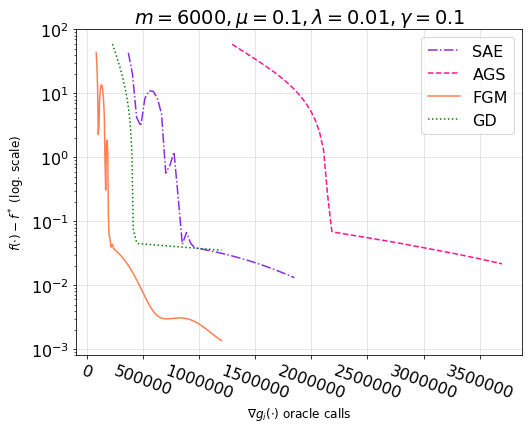

In [41]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.plot(dg_list_SAE, vals_SAE - f_star, 'blueviolet', label='SAE', ls='-.')
plt.plot(dg_list_AGS, vals_AGS - f_star, 'deeppink', label='AGS', ls='--')
plt.plot(dg_list_FGM, vals_FGM - f_star, 'coral', label='FGM', ls='-')
plt.plot(dg_list_GD, vals_GD - f_star, 'green', label='GD', ls=':')
plt.yscale('log')

plt.grid(alpha=0.4)
plt.title(f'$m = {MAX_SAMPLES}, \\mu = {MU}, \\lambda = {LAMBDA}, \gamma = {GAMMA}$')
plt.xlabel('$\\nabla g_i(\\cdot)$ oracle calls', fontsize=12)
plt.xticks(rotation=-20)
if f_star != 0.0:
    plt.ylabel('$f(\\cdot) - f^*$ (log. scale)', fontsize=12)
else:
    plt.ylabel('$f(\\cdot)$ (log. scale)', fontsize=12)
plt.legend()

if SAVE:
    plt.savefig(f'figures/m={MAX_SAMPLES}_mu={MU}_lambda={LAMBDA}_gamma={GAMMA}_gi_calls.pdf')
plt.show()

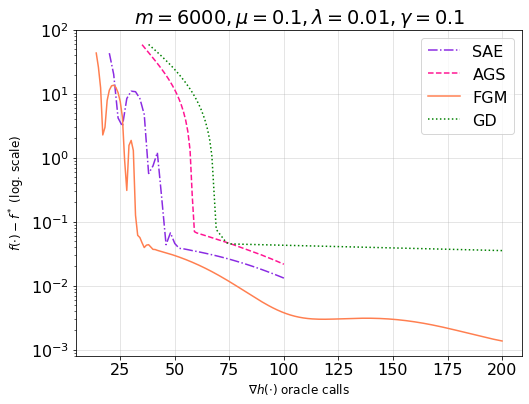

In [40]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.plot(dh_list_SAE, vals_SAE - f_star, 'blueviolet', label='SAE', ls='-.')
plt.plot(dh_list_AGS, vals_AGS - f_star, 'deeppink', label='AGS', ls='--')
plt.plot(dh_list_FGM, vals_FGM - f_star, 'coral', label='FGM', ls='-')
plt.plot(dh_list_GD, vals_GD - f_star, 'green', label='GD', ls=':')
plt.yscale('log')

plt.grid(alpha=0.4)
plt.title(f'$m = {MAX_SAMPLES}, \\mu = {MU}, \\lambda = {LAMBDA}, \gamma = {GAMMA}$')
plt.xlabel('$\\nabla h(\\cdot)$ oracle calls', fontsize=12)
if f_star != 0.0:
    plt.ylabel('$f(\\cdot) - f^*$ (log. scale)', fontsize=12)
else:
    plt.ylabel('$f(\\cdot)$ (log. scale)', fontsize=12)
plt.legend()

if SAVE:
    plt.savefig(f'figures/m={MAX_SAMPLES}_mu={MU}_lambda={LAMBDA}_gamma={GAMMA}_h_calls.pdf')
plt.show()

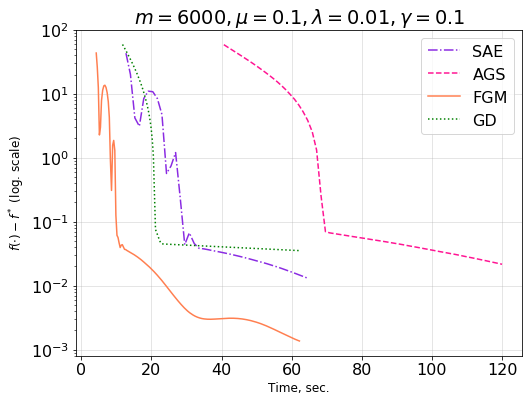

In [39]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.plot(times_SAE, vals_SAE - f_star, 'blueviolet', label='SAE', ls='-.')
plt.plot(times_AGS, vals_AGS - f_star, 'deeppink', label='AGS', ls='--')
plt.plot(times_FGM, vals_FGM - f_star, 'coral', label='FGM', ls='-')
plt.plot(times_GD, vals_GD - f_star, 'green', label='GD', ls=':')
plt.yscale('log')

plt.grid(alpha=0.4)
plt.title(f'$m = {MAX_SAMPLES}, \\mu = {MU}, \\lambda = {LAMBDA}, \gamma = {GAMMA}$')
plt.xlabel('Time, sec.', fontsize=12)
if f_star != 0.0:
    plt.ylabel('$f(\\cdot) - f^*$ (log. scale)', fontsize=12)
else:
    plt.ylabel('$f(\\cdot)$ (log. scale)', fontsize=12)
plt.legend()

if SAVE:
    plt.savefig(f'figures/m={MAX_SAMPLES}_mu={MU}_lambda={LAMBDA}_gamma={GAMMA}_time.pdf')
plt.show()